In [394]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.stats import norm

from coprofile import COProfile, COGenerator
from likelihood import ModelLikelihood

import random

from time import time

In [395]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [396]:
fixed='past' # 14CO production rate fixed in past for variable models
#fixed='pres' # 14CO production rate fixed at present for variable models

sample='one' # null model samples are drawn from a single null model 
#sample='mult' # null model samples are drawn from a random null model

priors='unif' # uniform priors on f_factors
#priors='non-unif' # non-uniform priors on f_factors from chi^2 data 

f_factors='const' # only constant models parameterize over f_factors
#f_factors='all' # all models parameterize over f_factors

null='null-in' # linear and step models include constant models
#null='null-out' # linear and step models disinclude constant models

In [397]:
fmu_neg, fmu_fast = 0.066, 0.072

In [398]:
depthavg = 20.   # in meters
relerror = 0.02 

const_models = ModelLikelihood('FITS_models/balco_14co_const_models.fits', depth_avg=depthavg, rel_uncertainty=relerror)
linear_models = ModelLikelihood('FITS_models/balco_14co_linear_models_{}_{}_{}.fits'.format(fixed, f_factors, null),
                                depth_avg=depthavg, rel_uncertainty=relerror)
step_models = ModelLikelihood('FITS_models/balco_14co_step_models_{}_{}_{}.fits'.format(fixed, f_factors, null),
                              depth_avg=depthavg, rel_uncertainty=relerror)
burst_models = ModelLikelihood('FITS_models/balco_14co_burst_models_{}.fits'.format(f_factors),
                               depth_avg=depthavg, rel_uncertainty=relerror)

if priors=='non-unif':
    const_models.import_prior('14CO_f_all_ChiSq.csv')
    linear_models.import_prior('14CO_f_all_ChiSq.csv')
    step_models.import_prior('14CO_f_all_ChiSq.csv')
    burst_models.import_prior('14CO_f_all_ChiSq.csv')
    
Models = [const_models, linear_models, step_models, burst_models] # 0: const; 1: linear; 2: step; 3: burst
modelNames = ['constant', 'linear', 'step', 'burst']

## f_factors Graph

Text(0.5, 1.0, 'Constant Model f_factors')

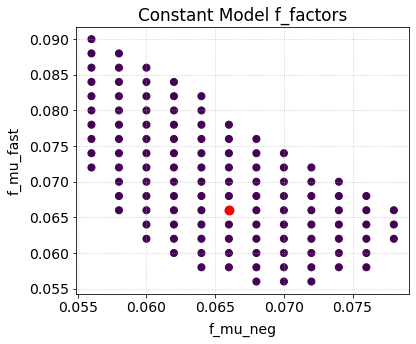

In [399]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.scatter(const_models.fofactors['FOMUNEG'],const_models.fofactors['FOMUFAST'], s=np.exp(const_models.logprior)*50)
ax.scatter(fmu_neg, fmu_neg, c='red', s=80)
ax.set(xlabel='f_mu_neg',
        ylabel='f_mu_fast')
plt.title('Constant Model f_factors')

## CO Profiles

In [400]:
def param_dist(model, theta0, weights = [1]): # calculates distance in parameter space to theta0
    w = np.array(weights)
    theta0 = np.array(theta0)
    return np.sum(w * (model.parameters - theta0)**2, axis=1)

In [401]:
def param_chi2(model, CO_samp, dCO_samp):
    return np.sum(((model.CO_mods - CO_samp)/dCO_samp)**2, axis=1)

In [423]:
a = np.array([np.sum(p.CO) for p in burst_models.models])

index = a.argsort()
print(index)
ind = index[np.arange(len(index)-1,-1,-10)]
print(a[ind])
i0 = a.argmin()

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89  9]
[174100.45231841 172246.04810787 170391.64389733 168537.23968679
 166682.83547625 164828.43126572 162974.02705518 161119.62284464
 159265.2186341 ]


Text(0.5, 1.0, 'Burst Model CO Profiles')

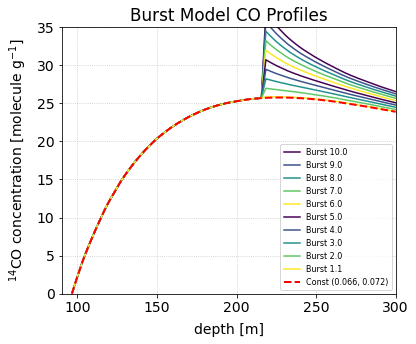

In [426]:
dist = param_dist(const_models, [fmu_neg, fmu_fast])
j = dist.argmin()
data_const = const_models.models[j]

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
for i in ind:
    ax.plot(burst_models.models[i].z, burst_models.models[i].CO, label='Burst {}'.format(burst_models.parameters[i,0]))
ax.plot(burst_models.models[i0].z, burst_models.models[i0].CO, label='Burst {}'.format(burst_models.parameters[i0,0]))
ax.plot(data_const.z, data_const.CO, ls='--', lw=2, c='red', label='Const ({:.3f}, {:.3f})'.format(fmu_neg, fmu_fast))
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,35),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=8)
plt.title('Burst Model CO Profiles')

## CO Samples

In [404]:
def plot_model(m, theta0 = []): # plots model# m against constant model, takes random sample, and calculates Bayes factors
    dist = param_dist(const_models, [fmu_neg, fmu_fast])
    i = dist.argmin()
    data_const = const_models.models[i]
    
    #dist = param_dist(Models[m], theta0s[m])
    #j = dist.argmin()
    #data_lin = Models[m].models[j]
    if theta0 == []:
        j = random.choices(np.arange(len(Models[m].models)), weights=np.exp(Models[m].logprior))[0]
        data_lin = Models[m].models[j]
    else:
        dist = param_dist(Models[m], theta0)
        j = dist.argmin()
        data_lin = Models[m].models[j]
    print('params: {}'.format(Models[m].parameters[j]))
    
    z_samp, CO_samp, dCO_samp = data_lin.sample_z()
    
    fit_models = const_models
    chi2 = param_chi2(fit_models, CO_samp, dCO_samp) - 2*fit_models.logprior
    i = chi2.argmin()
    const_fit = fit_models.models[i]
    print('const fit params: {}'.format(fit_models.parameters[i]))
    print(chi2[i])
    print()

    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    #ax.plot(data_const.z, data_const.CO, 'r--', label='constant model')
    ax.plot(data_lin.z, data_lin.CO, lw=2, label='Const ({:.3f}, {:.3f})'.format(fmu_neg,fmu_fast))
    #ax.plot(const_fit.z, const_fit.CO, 'g--', label='constant fit')
    ax.errorbar(z_samp, CO_samp, yerr=dCO_samp, fmt='.', label='sample')
    ax.set(xlim=(90,300),
           xlabel='depth [m]',
           ylim=(0,35),
           ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
    ax.legend(loc='lower right', fontsize=10)
    plt.title('Constant Model 14CO Profile Sample')

    # Try out some likelihood ratio tests.
    B01 = const_models.likelihood(z_samp, CO_samp, dCO_samp) / linear_models.likelihood(z_samp, CO_samp, dCO_samp)
    print(f'B_01 = {B01:12g}; 0=const model, 1=linear model')

    B02 = const_models.likelihood(z_samp, CO_samp, dCO_samp) / step_models.likelihood(z_samp, CO_samp, dCO_samp)
    print(f'B_02 = {B02:12g}; 0=const model, 2=step model')

    B03 = const_models.likelihood(z_samp, CO_samp, dCO_samp) / burst_models.likelihood(z_samp, CO_samp, dCO_samp)
    print(f'B_03 = {B03:12g}; 0=const model, 3=burst model')

## Null Hypothesis Data

In [405]:
null_file = 'FITS_models/bf_null_20m_2pct_5000000_{}_{}_{}_{}_{}_01.npz'.format(fixed, sample, priors, f_factors, null)

if os.path.exists(null_file):
    npzf = np.load(null_file)
    BF_lin_null = npzf['BF_lin']
    BF_step_null = npzf['BF_step']
    BF_100yr_null = npzf['BF_100yr']
    BF_null = [BF_lin_null, BF_step_null, BF_100yr_null]
else:
    print('Null data path does not exist')

[6748  157    0]
[[1.52953236e+00 1.20511670e+00 8.51366208e-01]
 [1.05578747e+00 5.53112193e-01 2.01231387e-01]
 [4.82200509e-02 7.32426085e-03 4.58644304e-04]]


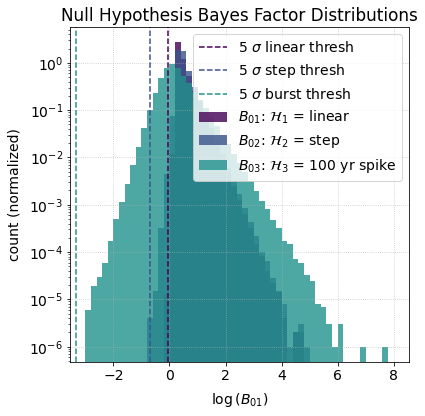

In [406]:
N = len(BF_lin_null)

sigs = [3,4,5]

i = np.array([np.maximum(int(norm.sf(x)*N)-1,0) for x in sigs])
print(i)

sig_thr = np.array([np.sort(nulls)[i] for nulls in BF_null])
print(sig_thr)

BFlim = (-20,50)

logBmin = np.maximum(np.round(np.log10(np.min(np.minimum(np.minimum(BF_lin_null, BF_100yr_null), BF_step_null)))),BFlim[0])
logBmax = np.minimum(np.round(np.log10(np.max(np.maximum(np.maximum(BF_lin_null, BF_100yr_null), BF_step_null)))),BFlim[1])
nbins = int(np.round((logBmax - logBmin) / 0.2) + 1)

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.hist(np.log10(BF_lin_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{01}$: $\mathcal{H}_1$ = linear');
ax.hist(np.log10(BF_step_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{02}$: $\mathcal{H}_2$ = step');
ax.hist(np.log10(BF_100yr_null), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
        label=r'$B_{03}$: $\mathcal{H}_3$ = 100 yr spike');
ax.axvline(np.log10(sig_thr[0,2]), ls = '--', c=colors[0], label=r'5 $\sigma$ linear thresh')
ax.axvline(np.log10(sig_thr[1,2]), ls = '--', c=colors[1], label=r'5 $\sigma$ step thresh')
ax.axvline(np.log10(sig_thr[2,2]), ls = '--', c=colors[2], label=r'5 $\sigma$ burst thresh')
ax.set(xlabel=r'$\log{(B_{01})}$',
       ylabel='count (normalized)',
       yscale='log')

ax.legend(loc='best')
plt.title('Null Hypothesis Bayes Factor Distributions')

fig.tight_layout()

Text(0.5, 1.0, 'Null Hypothesis Bayes Factor Distributions')

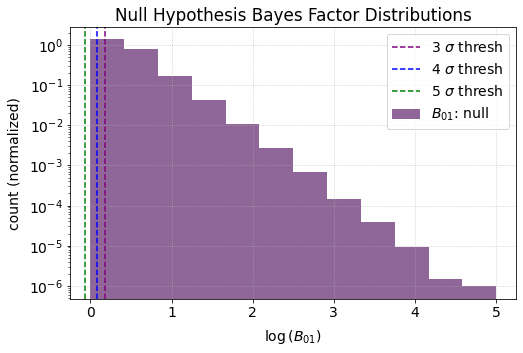

In [407]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

logBmin = np.round(np.log10(np.min(BF_null[0])))
logBmax = np.round(np.log10(np.max(BF_null[0])))
nbins = int(np.round((logBmax - logBmin) / 0.4) + 1)

ax.hist(np.log10(BF_null[0]), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.6, density=1,
        label=r'$B_{01}$: null');
ax.axvline(np.log10(sig_thr[0][0]), ls = '--', c='purple', label=r'3 $\sigma$ thresh')
ax.axvline(np.log10(sig_thr[0][1]), ls = '--', c='blue', label=r'4 $\sigma$ thresh')
ax.axvline(np.log10(sig_thr[0][2]), ls = '--', c='green', label=r'5 $\sigma$ thresh')
ax.set(xlabel=r'$\log{(B_{01})}$',
        ylabel='count (normalized)',
        yscale='log'
        )

ax.legend(loc='best')
plt.title('Null Hypothesis Bayes Factor Distributions')

## CO Profile Generation

In [408]:
def plot_factors(t, neg, fast, slopes, sample=True):
    if len(np.shape(neg))==1:
        neg = np.array([neg])
    if len(np.shape(fast))==1:
        fast = np.array([fast])
    
    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,n in enumerate(neg):
        ax.plot(t, n, label='Burst {:.2f}'.format(slopes[i]))
    ax.axhline(fmu_neg, ls='--', lw=2, c='red', label='Const')
    ax.set(xlim=(min(t),max(t)),
           xlabel='time [yrs]',
            ylim=(0.,0.8),
            ylabel='f_mu_neg')
    ax.legend(loc='lower left', fontsize=10)
    plt.title('Burst Model f_neg')
    
    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,f in enumerate(fast):
        ax.plot(t, f, label='Burst {:.2f}'.format(slopes[i]))
    ax.axhline(fmu_fast, ls='--', lw=2, c='red', label='Const')
    ax.set(xlim=(min(t),max(t)),
            xlabel='time [yrs]',
            ylim=(0.,0.8),
            ylabel='f_mu_fast')
    ax.legend(loc='lower left', fontsize=10)
    plt.title('Burst Model f_fast')

In [409]:
def plot_profiles(profiles, slopes, sample=False):
    if len(np.shape(np.array(profiles))) == 0:
        p = np.array([profiles])
    else:
        p = np.array(profiles)
    

    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,profile in enumerate(p):
        ax.plot(profile.z, profile.CO, label='Burst {:.2f}'.format(slopes[i]))
    ax.plot(const_profile.z, const_profile.CO, ls='--', lw=2, c='red', label='Const')
    if sample:
        z_samp, CO_samp, dCO_samp = p[0].sample_z()
        ax.errorbar(z_samp, CO_samp, yerr=dCO_samp, fmt='.')
    ax.set(xlim=(90,300),
            xlabel='depth [m]',
            ylim=(0,35),
            ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
    ax.legend(loc='lower right', fontsize=10)
    plt.title('Burst Model CO Profiles')

In [410]:
generator = COGenerator('models/balco_14co_delta_neg_models.fits', 'models/balco_14co_delta_fast_models.fits')

In [411]:
const_profile = generator.generate()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.09it/s]


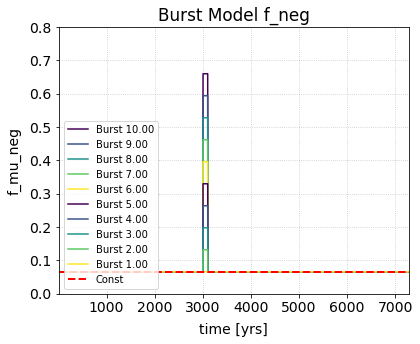

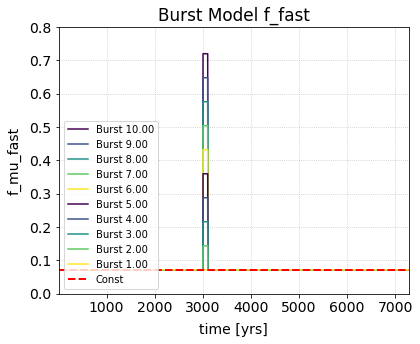

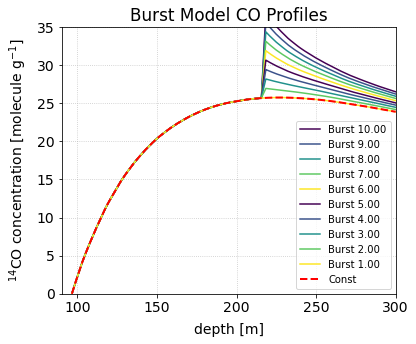

In [412]:
slopes = np.arange(10., 0., -1.)

t = generator.t
tmax = np.max(t)
tmid = int(tmax/2)
tmin = np.min(t)

#amp = 1 + np.expand_dims(slopes, axis=1) * (t-tmax)/(tmax-tmin) # linear
#amp = 1 + np.expand_dims(slopes, axis=1) * np.heaviside(t-tmid, 1) # step
#amp = 1 + np.expand_dims(slopes, axis=1) * np.heaviside(tmid-t, 0) # step

amp = np.ones((len(slopes),len(t))) # burst
amp[:,3000:3100] *= np.expand_dims(slopes,axis=1)

neg = fmu_neg * amp
fast = fmu_fast * amp

linear_profiles = []
for i in tqdm(range(len(slopes))):
    linear_profiles.append(generator.generate(neg[i], fast[i]))
plot_factors(t, neg, fast, slopes)
    
linear_profiles = np.array(linear_profiles)

plot_profiles(linear_profiles, slopes)

## Sensitivity Calculations

In [413]:
def thresholds(m, theta0, nMC = 10000):
    dist = param_dist(Models[m], theta0)
    j = dist.argmin()
    model = Models[m].models[j]

    # model = COProfile('check_linear_1.14.txt')
    # model = COProfile('co14_linear1.15.txt')
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in tqdm(range(nMC)):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])

        # p-value is the tail of the null distribution BF_lin that is
        # less then or equal to the current Bayes Factor.
        # If the distributions don't overlap, then set p=1/N as a lower bound.
        #p = np.maximum(np.sum(BF_null[m-1] <= B) / N, 1./N)
        #sigma = norm.isf(p)

        #print(np.log10(B), p, sigma, sigma>np.asarray([3,4,5]))
        #for j, sig_thr in enumerate([3.,4.,5.]):
            #if sigma >= sig_thr:
                #bf_th[j] += 1

    print(bf_th / nMC)
    
    fig, ax = plt.subplots(1,1, figsize=(8,5))

    logBmin = np.round(np.log10(np.minimum(np.min(BF_null[m-1]), np.min(BF_store))))
    logBmax = np.round(np.log10(np.maximum(np.max(BF_null[m-1]), np.max(BF_store))))
    nbins = int(np.round((logBmax - logBmin) / 0.4) + 1)

    ax.hist(np.log10(BF_null[m-1]), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
            label=r'$B_{01}$: null'+' ({:.3f}, {:.3f})'.format(fmu_neg, fmu_fast));
    ax.hist(np.log10(BF_store), bins=np.linspace(logBmin, logBmax, nbins), alpha=0.8, density=1,
            label=r'$B_{01}$: burst'+' {}'.format(Models[m].parameters[j,0]));
    ax.axvline(np.log10(sig_thr[m-1][0]), ls = '--', c='purple', label=r'3 $\sigma$ thresh')
    ax.axvline(np.log10(sig_thr[m-1][1]), ls = '--', c='blue', label=r'4 $\sigma$ thresh')
    ax.axvline(np.log10(sig_thr[m-1][2]), ls = '--', c='green', label=r'5 $\sigma$ thresh')
    ax.set(xlabel=r'$\log{(B_{01})}$',
           ylabel='count (normalized)',
           yscale='log'
          )
    plt.title('Burst vs Constant Bayes Factor Distributions')

    ax.legend(loc='best')
    
    return bf_th/nMC

In [414]:
def sens_test(model, m, nMC):
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in range(nMC):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])
        
    return bf_th

In [415]:
def sens_test_show(model, m, nMC):
    bf_th = np.zeros(3, dtype=float)
    BF_store = np.zeros(nMC, dtype=float)
    N = len(BF_lin_null)

    for i in tqdm(range(nMC)):
        z_samp, CO_samp, dCO_samp = model.sample_z()
        B = const_models.likelihood(z_samp, CO_samp, dCO_samp) / Models[m].likelihood(z_samp, CO_samp, dCO_samp)
        BF_store[i] = B
        
        bf_th += (B <= sig_thr[m-1])
        
    return bf_th

In [416]:
def step(j, m, domain, sigs):
    #print(j)
    models = Models[m].models
    if j>0: # test if it could be lower
        s = sens_test(models[domain[j-1]], m, 1000)[sigs-3] #show
        #print(s)
        if s>= 500:
            return step(j-1, m, domain, sigs)
    s = sens_test(models[domain[j]], m, 1000)[sigs-3] #show
    #print(s)
    if s<500: # test if it's valid
        if j+1 >= len(domain):
            return -1
        else:
            return step(j+1, m, domain, sigs)
    # make sure it's valid
    #s = sens_test_show(models[domain[j]], m, 10000)[sigs-3]
    #print(s)
    #if s<5000:
        #if j+1 >= len(domain):
            #return -1
        #else:
            #return step(j+1, m, domain, sigs)
    return j

In [417]:
def sens_search(m, domain = [], sigs = 3):
    # domain should be an array of model indices sorted in ascending order of parameter cost
    
    models = Models[m].models
    s = np.array([sens_test(models[i], m, 10)[sigs-3] for i in domain]) #tqdm
    #print(s)
    options = np.arange(len(domain))[np.abs(s-5)<=4]
    s = np.array([sens_test(models[domain[i]], m, 50)[sigs-3] for i in options]) #tqdm
    #print(s)
    options = options[np.abs(s-25)<=15]
    s = np.array([sens_test(models[domain[i]], m, 200)[sigs-3] for i in options]) #tqdm
    #print(s)
    options = options[s>=90]
    j = options[0]
    
    thresh = step(j, m, domain, sigs)
    if thresh == -1:
        print('Sensitivity too high to detect')
        return
    else:
        return domain[thresh]

In [418]:
def auto_search(m, up=True, sigs = 3):
    cost = []
    s = 1 if up else -1
    for i,p in enumerate(Models[m].parameters):
        c = s*p[0]
        if c>=s:
            if len(p)==1:
                cost.append((i,c))
            elif p[1] == fmu_neg and p[2] == fmu_fast:
                cost.append((i,c))
    a = np.array(cost, dtype = [('index', int), ('cost', float)])
    domain = np.sort(a, order='cost')['index']
    
    j = sens_search(m, domain, sigs)
    params = Models[m].parameters[j]
    thresholds(m, params)
    print('{} Sigma Amplitude Sensitivity: {}'.format(sigs, params[0]))
    return

In [419]:
null_file = 'FITS_models/bf_null_20m_2pct_5000000_{}_{}_{}_{}_{}_01.npz'.format(fixed, sample, priors, f_factors, null)

if os.path.exists(null_file):
    npzf = np.load(null_file)
    BF_lin_null = npzf['BF_lin']
    BF_step_null = npzf['BF_step']
    BF_100yr_null = npzf['BF_100yr']
    BF_null = [BF_lin_null, BF_step_null, BF_100yr_null]
else:
    print('Null data path does not exist')

In [420]:
N = len(BF_lin_null)

sigs = [3,4,5]

i = np.array([np.maximum(int(norm.sf(x)*N)-1,0) for x in sigs])
print(i)

sig_thr = np.array([np.sort(nulls)[i] for nulls in BF_null])
print(sig_thr)

[6748  157    0]
[[1.52953236e+00 1.20511670e+00 8.51366208e-01]
 [1.05578747e+00 5.53112193e-01 2.01231387e-01]
 [4.82200509e-02 7.32426085e-03 4.58644304e-04]]


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16077.18it/s]


[0.5007 0.2164 0.0377]
3 Sigma Amplitude Sensitivity: 2.5


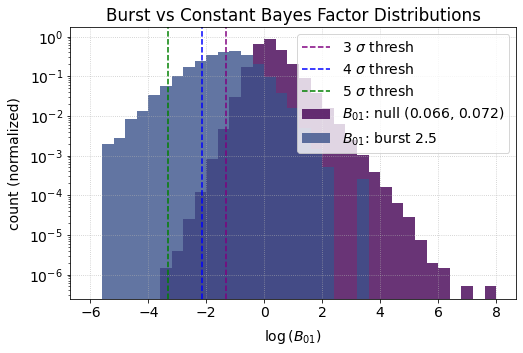

In [421]:
auto_search(3, True, 3)

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 16103.07it/s]


[0.9159 0.7934 0.5089]
5 Sigma Amplitude Sensitivity: 3.5


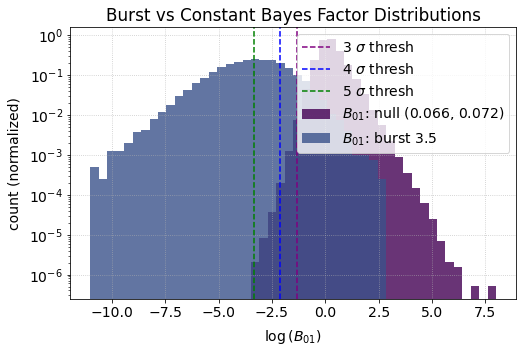

In [422]:
auto_search(3, True, 5)